In [19]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from sklearn import metrics
from sklearn.neighbors import NearestCentroid
from math import pi
from sklearn.cluster import AgglomerativeClustering

### Functions to describe clusters

In [2]:
def plot_parallel_coordinates_clusters(df, cluster_centers):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(cluster_centers)):
        plt.plot(cluster_centers[i], marker='o', label='Cluster %s' % i)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(range(0, len(df.columns)), df.columns, fontsize=18)
    plt.legend(fontsize=10)
    plt.show()

In [3]:
def plot_radar_clusters(df, cluster_centers):
    # number of variable
    N = len(df.columns)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    for i in range(0, len(cluster_centers)):
        angles = [n / float(N) * 2 * pi for n in range(N)]
        values = cluster_centers[i].tolist()
        values += values[:1]
        angles += angles[:1]
        # Initialise the spider plot
        ax = plt.subplot(polar=True)
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], df.columns, color='grey', size=8) 
        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid')
        # Fill area
        ax.fill(angles, values, 'b', alpha=0.1)

In [4]:
def plot_date_feature_clusters(df, labels, num_cluster):

    for i in range(num_cluster):
        i_samples = labels==i
        df_cat[i_samples].name.groupby(pd.to_datetime(df_cat.loc[i_samples, 'created_at'], format='%Y-%m-%d %H:%M:%S', errors='raise').dt.year).count().plot(kind="bar")
        plt.show()

In [5]:
def categorical_hist_clusters(df, labels, feature_name):
    bot_xt_pct = pd.crosstab(labels, df[feature_name])
    bot_xt_pct.plot(kind='bar', stacked=False, 
                       title=f'{feature_name} per cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature_name)
    plt.show()

In [6]:
def plot_numerical_features_clusters(df, labels, num_cluster):
    """
    print and plot distribution of numerical features conditioned by the cluster
    """
    
    for i in range(num_cluster):
        i_samples = labels==i
        df[i_samples].boxplot()
        df[i_samples].hist()
        plt.show()

In [7]:
def scatter_features_clusters(df, labels):
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            feature_1 = df.columns[i]
            feature_2 = df.columns[j]
            
            print(f"{feature_1} - {feature_2}")
            plt.scatter(df[feature_1], df[feature_2], c=labels, s=20)
            plt.tick_params(axis='both', which='major', labelsize=22)
            plt.show()

### Preparation of the dataset

In [8]:
df = pd.read_csv("dataset/user_profiles.csv", skipinitialspace=True, sep=',')

In [9]:
df.head()

Unnamed: 0              name lang  bot           created_at  \
0  2353593986   Lamonica Raborn   en    1  2019-02-22 18:00:42   
1  2358850842     Lourie Botton   en    0  2019-02-26 03:02:32   
2   137959629  Dadan Syarifudin   en    1  2015-04-30 07:09:56   
3   466124818    Carletto Focia   it    1  2017-01-18 02:49:18   
4  2571493866         MBK Ebook   en    0  2019-06-18 19:30:21   

   statuses_count  avg_length  avg_special_chars  urls_ratio  mentions_ratio  \
0              76   62.340909          14.015152    0.000000        0.272727   
1               4   69.082645          15.041322    0.000000        0.338843   
2               7   19.250000           5.250000    0.000000        0.000000   
3              50   86.944871          18.689463    0.022331        0.006281   
4               8   72.311246          14.582073    0.000825        0.506461   

   hashtags_ratio  reply_count_mean  reply_count_std  reply_count_entropy  \
0        0.098485               0.0              0.0                  0.0   
1        0.024793               0.0              0.0                  0.0   
2        0.000000               0.0              0.0                  0.0   
3        0.072575               0.0              0.0                  0.0   
4        0.118229               0.0              0.0                  0.0   

   favorite_count_mean  favorite_count_std  favorite_count_entropy  \
0             0.037879            0.190903                1.609438   
1             0.049587            0.217090                1.791759   
2             0.000000            0.000000                0.000000   
3             0.165387            0.530838                5.105129   
4             0.056365            0.243387                5.248623   

   retweet_count_mean  retweet_count_std  retweet_count_entropy  
0            0.037879           0.190903               1.609438  
1            0.024793           0.155495               1.098612  
2            0.000000           0.000000               0.000000  
3            0.826239          13.034008               2.170410  
4            0.016772           0.142619               3.965939

In [10]:
df_cat = df[['name','lang','created_at', 'bot']]
del df['name']
del df['lang']
del df['created_at']
del df['bot']
df.head()

Unnamed: 0  statuses_count  avg_length  avg_special_chars  urls_ratio  \
0  2353593986              76   62.340909          14.015152    0.000000   
1  2358850842               4   69.082645          15.041322    0.000000   
2   137959629               7   19.250000           5.250000    0.000000   
3   466124818              50   86.944871          18.689463    0.022331   
4  2571493866               8   72.311246          14.582073    0.000825   

   mentions_ratio  hashtags_ratio  reply_count_mean  reply_count_std  \
0        0.272727        0.098485               0.0              0.0   
1        0.338843        0.024793               0.0              0.0   
2        0.000000        0.000000               0.0              0.0   
3        0.006281        0.072575               0.0              0.0   
4        0.506461        0.118229               0.0              0.0   

   reply_count_entropy  favorite_count_mean  favorite_count_std  \
0                  0.0             0.037879            0.190903   
1                  0.0             0.049587            0.217090   
2                  0.0             0.000000            0.000000   
3                  0.0             0.165387            0.530838   
4                  0.0             0.056365            0.243387   

   favorite_count_entropy  retweet_count_mean  retweet_count_std  \
0                1.609438            0.037879           0.190903   
1                1.791759            0.024793           0.155495   
2                0.000000            0.000000           0.000000   
3                5.105129            0.826239          13.034008   
4                5.248623            0.016772           0.142619   

   retweet_count_entropy  
0               1.609438  
1               1.098612  
2               0.000000  
3               2.170410  
4               3.965939

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [12]:
scaler = StandardScaler()
scaler.fit(df.values)
X = scaler.fit_transform(df.values)

In [13]:
X[:5]

array([[ 1.15363293,  0.33593189, -0.35784931, -0.26859356, -0.47751096,
        -0.22247583, -0.19834274, -0.08312265, -0.12432158, -0.24648729,
        -0.2547907 , -0.34893963, -0.45495561, -0.33164564, -0.61495354,
        -0.30601295],
       [ 1.15925299, -0.58101623,  0.05815912, -0.08056663, -0.47751096,
        -0.0397904 , -0.54486366, -0.08312265, -0.12432158, -0.24648729,
        -0.24023803, -0.32378925, -0.37748204, -0.33272276, -0.61646742,
        -0.55341544],
       [-1.21508478, -0.54281006, -3.01683541, -1.8746464 , -0.47751096,
        -0.97605324, -0.66145014, -0.08312265, -0.12432158, -0.24648729,
        -0.30187286, -0.53228851, -1.13885118, -0.33476361, -0.62311564,
        -1.08549411],
       [-0.86424589,  0.00481174,  1.16037331,  0.58788801, -0.35248456,
        -0.9586994 , -0.32017909, -0.08312265, -0.12432158, -0.24648729,
        -0.09630158, -0.02245647,  1.03046228, -0.2667522 , -0.06584438,
        -0.03432346],
       [ 1.38658802, -0.53007467,  0

# Hierarchical Clustering

In [14]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [15]:
metric = ['canberra', 'chebyshev', 'cityblock', 'correlation', 'dice', 'hamming', 'jaccard', 'jensenshannon', 'kulczynski1', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']
method = ['single', 'average', 'complete']

##### Canberra

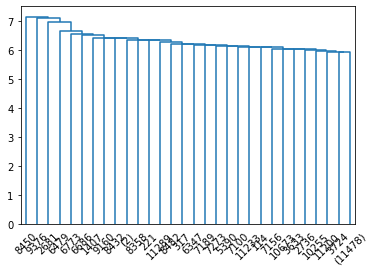

In [16]:
data_dist = pdist(X, metric=metric[0])
data_link = linkage(data_dist, method=method[0], metric=metric[0])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

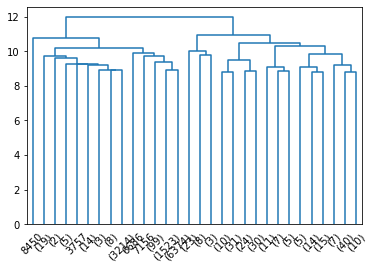

In [17]:
data_dist = pdist(X, metric=metric[0])
data_link = linkage(data_dist, method=method[1], metric=metric[0])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

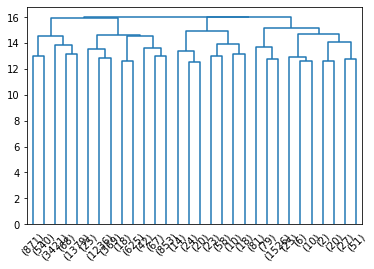

In [18]:
data_dist = pdist(X, metric=metric[0])
data_link = linkage(data_dist, method=method[2], metric=metric[0])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

###### chebyshev

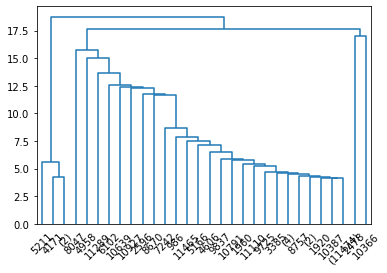

In [19]:
data_dist = pdist(X, metric=metric[1])
data_link = linkage(data_dist, method=method[0], metric=metric[1])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

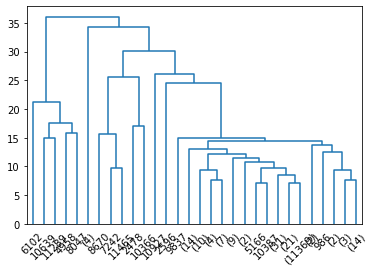

In [20]:
data_dist = pdist(X, metric=metric[1])
data_link = linkage(data_dist, method=method[1], metric=metric[1])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

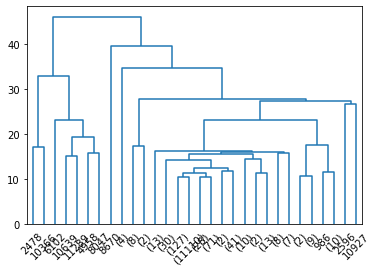

In [21]:
data_dist = pdist(X, metric=metric[1])
data_link = linkage(data_dist, method=method[2], metric=metric[1])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

###### cityblock

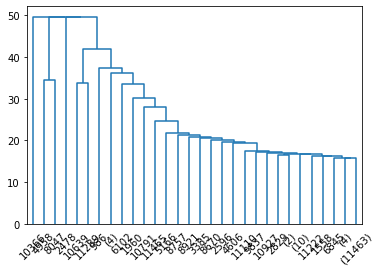

In [22]:
data_dist = pdist(X, metric=metric[2])
data_link = linkage(data_dist, method=method[0], metric=metric[2])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

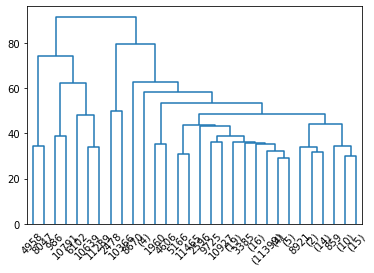

In [23]:
data_dist = pdist(X, metric=metric[2])
data_link = linkage(data_dist, method=method[1], metric=metric[2])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

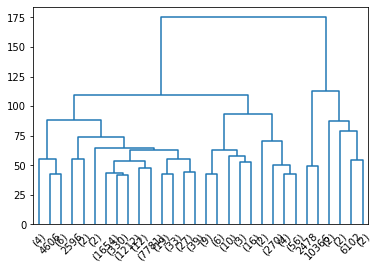

In [24]:
data_dist = pdist(X, metric=metric[2])
data_link = linkage(data_dist, method=method[2], metric=metric[2])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

###### correlation

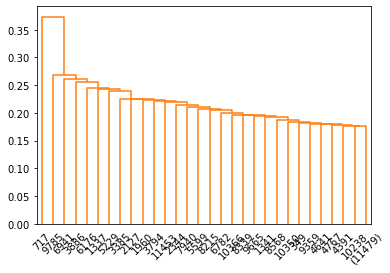

In [25]:
data_dist = pdist(X, metric=metric[3])
data_link = linkage(data_dist, method=method[0], metric=metric[3])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

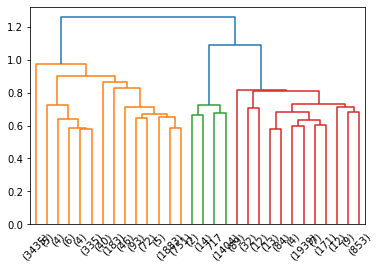

In [26]:
data_dist = pdist(X, metric=metric[3])
data_link = linkage(data_dist, method=method[1], metric=metric[3])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

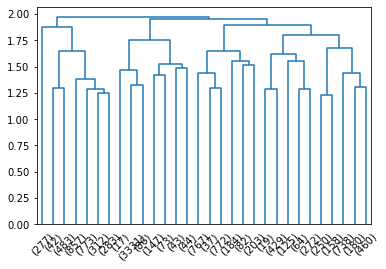

In [27]:
data_dist = pdist(X, metric=metric[3])
data_link = linkage(data_dist, method=method[2], metric=metric[3])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

###### dice

C:\Users\espos\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


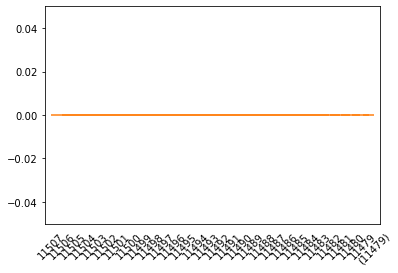

In [28]:
data_dist = pdist(X, metric=metric[4])
data_link = linkage(data_dist, method=method[0], metric=metric[4])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

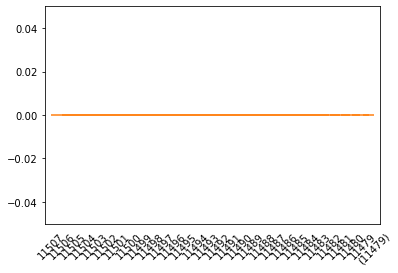

In [29]:
data_dist = pdist(X, metric=metric[4])
data_link = linkage(data_dist, method=method[1], metric=metric[4])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

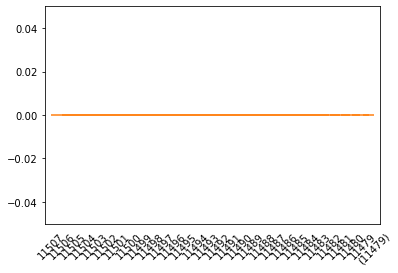

In [30]:
data_dist = pdist(X, metric=metric[4])
data_link = linkage(data_dist, method=method[2], metric=metric[4])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

###### hamming

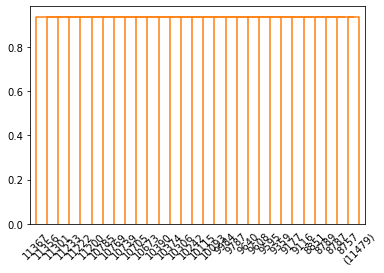

In [31]:
data_dist = pdist(X, metric=metric[5])
data_link = linkage(data_dist, method=method[0], metric=metric[5])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

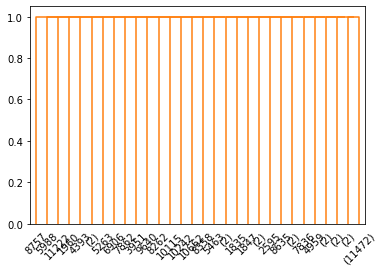

In [32]:
data_dist = pdist(X, metric=metric[5])
data_link = linkage(data_dist, method=method[1], metric=metric[5])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

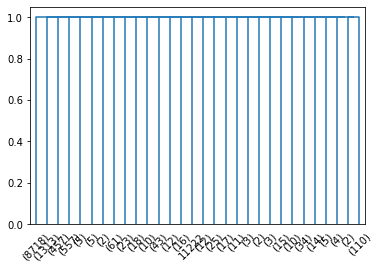

In [33]:
data_dist = pdist(X, metric=metric[5])
data_link = linkage(data_dist, method=method[2], metric=metric[5])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

###### jaccard

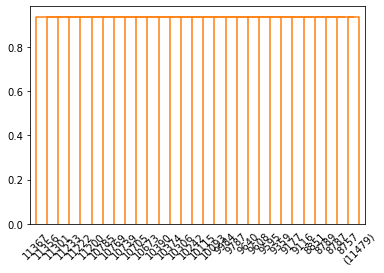

In [34]:
data_dist = pdist(X, metric=metric[6])
data_link = linkage(data_dist, method=method[0], metric=metric[6])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

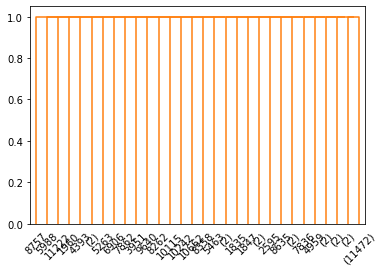

In [35]:
data_dist = pdist(X, metric=metric[6])
data_link = linkage(data_dist, method=method[1], metric=metric[6])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

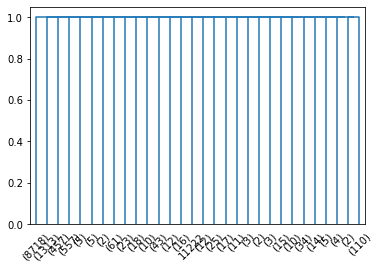

In [36]:
data_dist = pdist(X, metric=metric[6])
data_link = linkage(data_dist, method=method[2], metric=metric[6])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### jensenshannon (solo numeri finiti)

In [37]:
'''data_dist = pdist(X, metric=metric[7])
data_link = linkage(data_dist, method=method[0], metric=metric[7])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

ValueError: The condensed distance matrix must contain only finite values.

In [ ]:
'''data_dist = pdist(X, metric=metric[7])
data_link = linkage(data_dist, method=method[1], metric=metric[7])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

In [ ]:
'''data_dist = pdist(X, metric=metric[7])
data_link = linkage(data_dist, method=method[2], metric=metric[7])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

##### kulczynski1 (sconosciuto)

In [38]:
'''data_dist = pdist(X, metric=metric[8])
data_link = linkage(data_dist, method=method[0], metric=metric[8])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

ValueError: Unknown Distance Metric: kulczynski1

In [ ]:
'''data_dist = pdist(X, metric=metric[8])
data_link = linkage(data_dist, method=method[1], metric=metric[8])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

In [ ]:
'''data_dist = pdist(X, metric=metric[8])
data_link = linkage(data_dist, method=method[2], metric=metric[8])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

##### mahalanobis

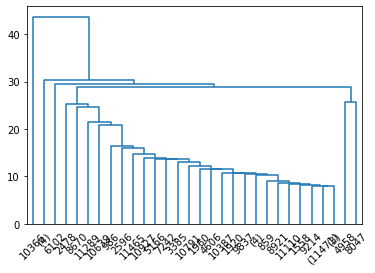

In [39]:
data_dist = pdist(X, metric=metric[9])
data_link = linkage(data_dist, method=method[0], metric=metric[9])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

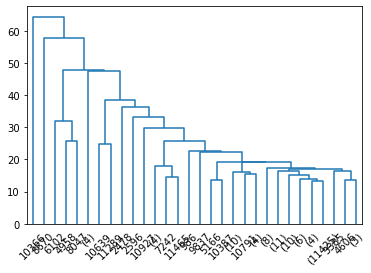

In [40]:
data_dist = pdist(X, metric=metric[9])
data_link = linkage(data_dist, method=method[1], metric=metric[9])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

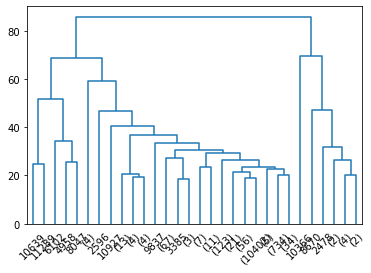

In [41]:
data_dist = pdist(X, metric=metric[9])
data_link = linkage(data_dist, method=method[2], metric=metric[9])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### matching

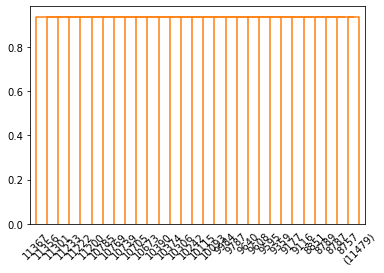

In [42]:
data_dist = pdist(X, metric=metric[10])
data_link = linkage(data_dist, method=method[0], metric=metric[10])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

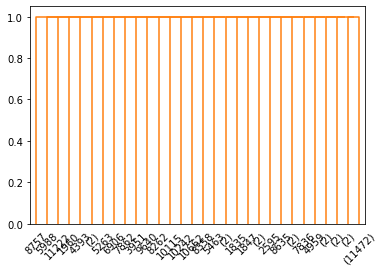

In [43]:
data_dist = pdist(X, metric=metric[10])
data_link = linkage(data_dist, method=method[1], metric=metric[10])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

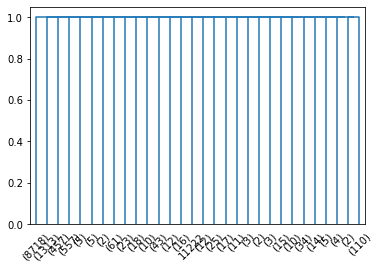

In [44]:
data_dist = pdist(X, metric=metric[10])
data_link = linkage(data_dist, method=method[2], metric=metric[10])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### minkowski

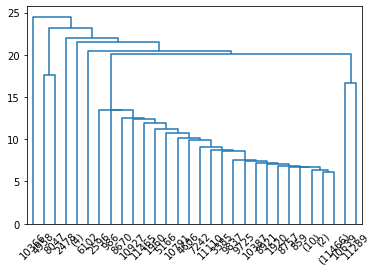

In [45]:
data_dist = pdist(X, metric=metric[11])
data_link = linkage(data_dist, method=method[0], metric=metric[11])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

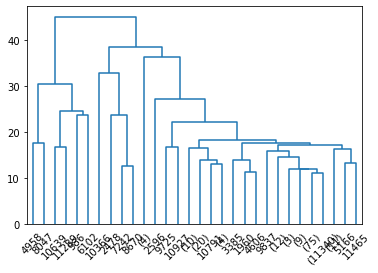

In [46]:
data_dist = pdist(X, metric=metric[11])
data_link = linkage(data_dist, method=method[1], metric=metric[11])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

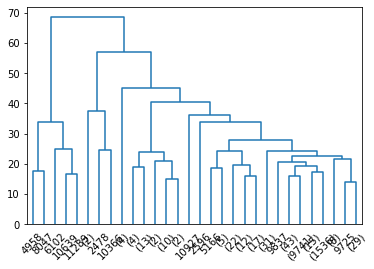

In [47]:
data_dist = pdist(X, metric=metric[11])
data_link = linkage(data_dist, method=method[2], metric=metric[11])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### rogerstanimoto

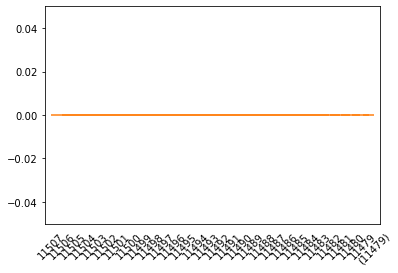

In [48]:
data_dist = pdist(X, metric=metric[12])
data_link = linkage(data_dist, method=method[0], metric=metric[12])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

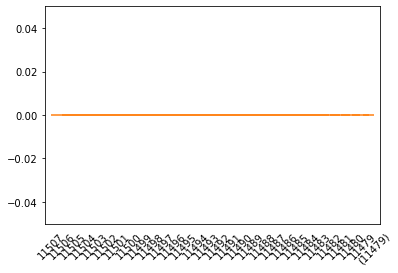

In [49]:
data_dist = pdist(X, metric=metric[12])
data_link = linkage(data_dist, method=method[1], metric=metric[12])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

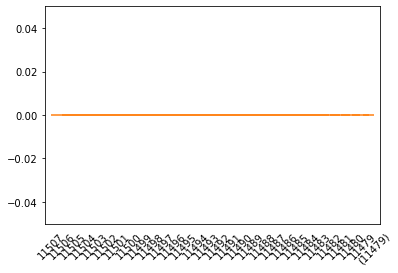

In [50]:
data_dist = pdist(X, metric=metric[12])
data_link = linkage(data_dist, method=method[2], metric=metric[12])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### russellrao

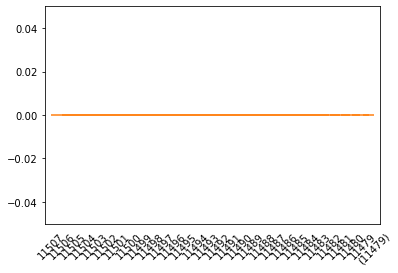

In [51]:
data_dist = pdist(X, metric=metric[13])
data_link = linkage(data_dist, method=method[0], metric=metric[13])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

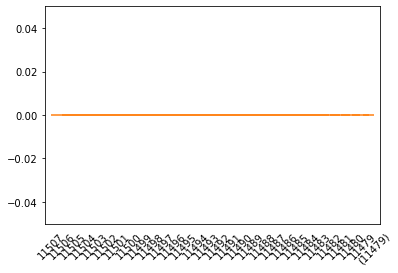

In [52]:
data_dist = pdist(X, metric=metric[13])
data_link = linkage(data_dist, method=method[1], metric=metric[13])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

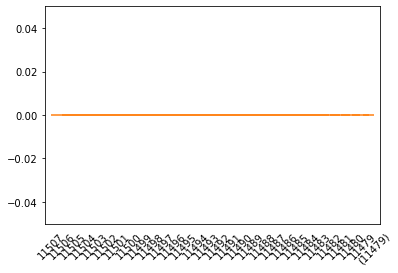

In [53]:
data_dist = pdist(X, metric=metric[13])
data_link = linkage(data_dist, method=method[2], metric=metric[13])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### seuclidean

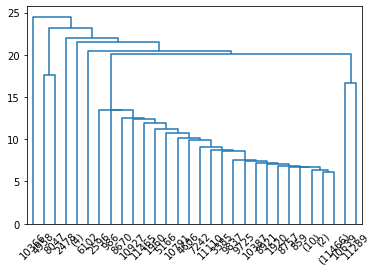

In [54]:
data_dist = pdist(X, metric=metric[14])
data_link = linkage(data_dist, method=method[0], metric=metric[14])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

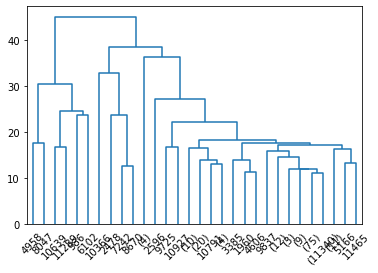

In [55]:
data_dist = pdist(X, metric=metric[14])
data_link = linkage(data_dist, method=method[1], metric=metric[14])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

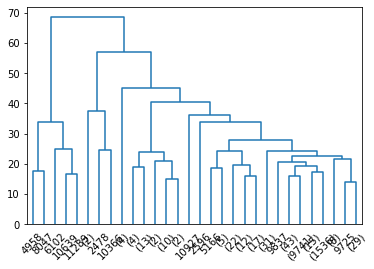

In [56]:
data_dist = pdist(X, metric=metric[14])
data_link = linkage(data_dist, method=method[2], metric=metric[14])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### sokalmichener

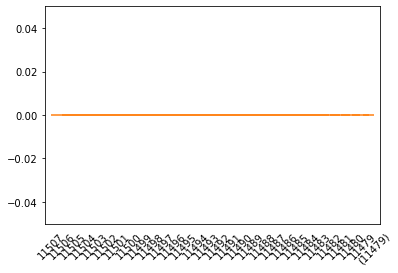

In [57]:
data_dist = pdist(X, metric=metric[15])
data_link = linkage(data_dist, method=method[0], metric=metric[15])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

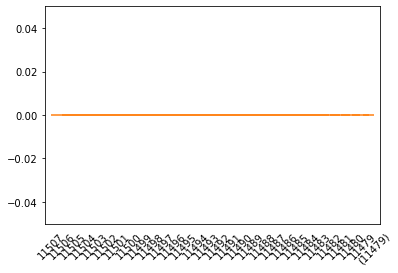

In [58]:
data_dist = pdist(X, metric=metric[15])
data_link = linkage(data_dist, method=method[1], metric=metric[15])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

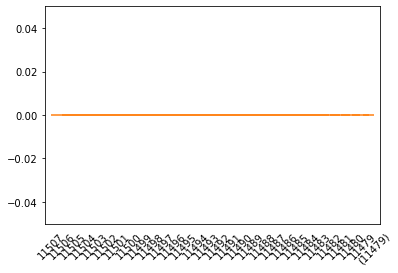

In [59]:
data_dist = pdist(X, metric=metric[15])
data_link = linkage(data_dist, method=method[2], metric=metric[15])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### sokalsneath

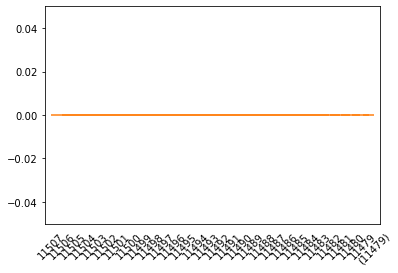

In [60]:
data_dist = pdist(X, metric=metric[16])
data_link = linkage(data_dist, method=method[0], metric=metric[16])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

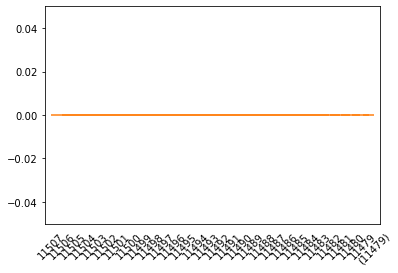

In [61]:
data_dist = pdist(X, metric=metric[16])
data_link = linkage(data_dist, method=method[1], metric=metric[16])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

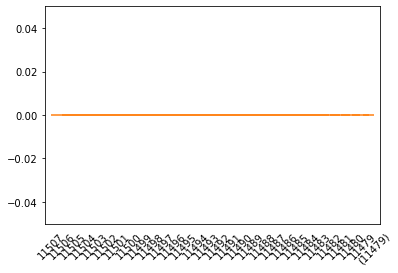

In [62]:
data_dist = pdist(X, metric=metric[16])
data_link = linkage(data_dist, method=method[2], metric=metric[16])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### sqeuclidean

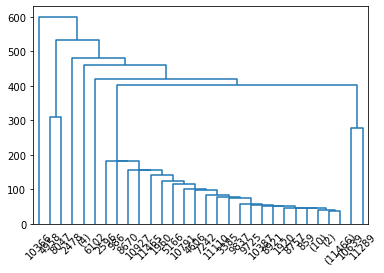

In [63]:
data_dist = pdist(X, metric=metric[17])
data_link = linkage(data_dist, method=method[0], metric=metric[17])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

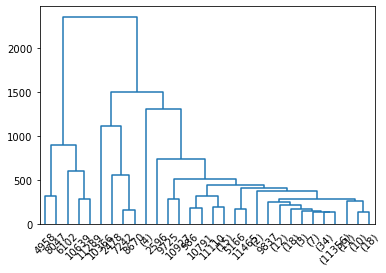

In [64]:
data_dist = pdist(X, metric=metric[17])
data_link = linkage(data_dist, method=method[1], metric=metric[17])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

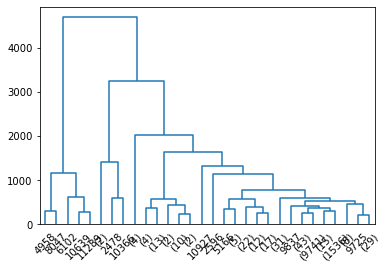

In [65]:
data_dist = pdist(X, metric=metric[17])
data_link = linkage(data_dist, method=method[2], metric=metric[17])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

##### yule

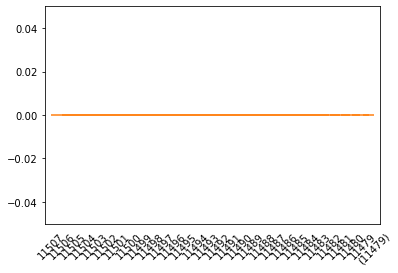

In [66]:
data_dist = pdist(X, metric=metric[18])
data_link = linkage(data_dist, method=method[0], metric=metric[18])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

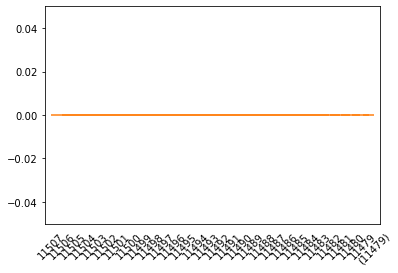

In [67]:
data_dist = pdist(X, metric=metric[18])
data_link = linkage(data_dist, method=method[1], metric=metric[18])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

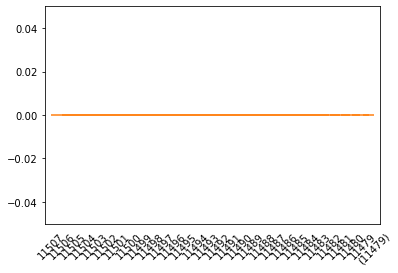

In [68]:
data_dist = pdist(X, metric=metric[18])
data_link = linkage(data_dist, method=method[2], metric=metric[18])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

In [69]:
from sklearn.cluster import AgglomerativeClustering

In [21]:
linkage = ['ward', 'complete', 'average', 'single']
affinity = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

##### AgglomerativeClustering with euclidean affinity

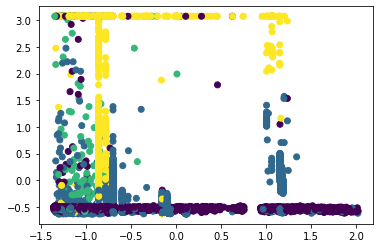

In [22]:
res_cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[0], linkage=linkage[0])
res_cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=res_cluster.labels_)

In [23]:
print('Silhouette %s' % silhouette_score(X, res_cluster.labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, res_cluster.labels_))

Silhouette 0.3691884320352231
Separation 1.4389726967694292


##### AgglomerativeClustering with l1 affinity

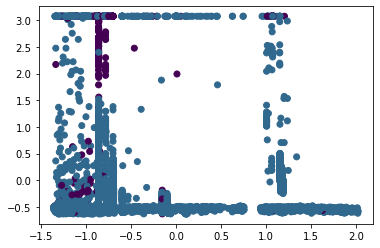

In [84]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[1], linkage=linkage[1])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [85]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.4869780510481968


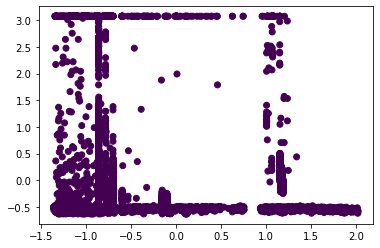

In [86]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[1], linkage=linkage[2])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [87]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.8719197952536678


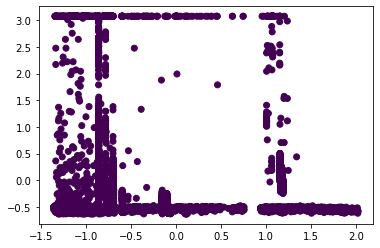

In [88]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[1], linkage=linkage[3])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [89]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.8834105859816775


##### AgglomerativeClustering with l2 affinity

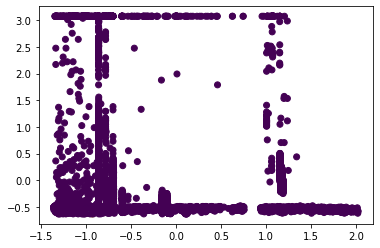

In [90]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[2], linkage=linkage[1])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [91]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.8733169838148203


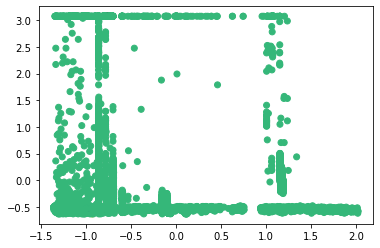

In [92]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[2], linkage=linkage[2])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [93]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.8733473694738749


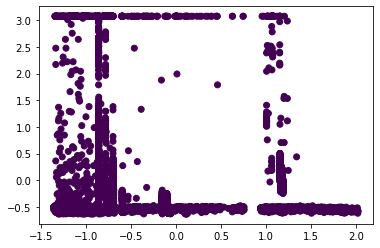

In [94]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[2], linkage=linkage[3])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [95]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.8834105859816775


##### AgglomerativeClustering with manhattan affinity

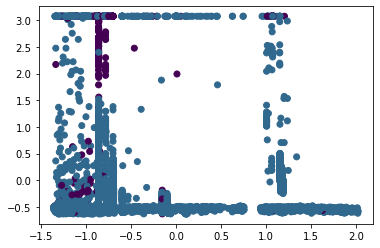

In [96]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[3], linkage=linkage[1])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [97]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.4869780510481968


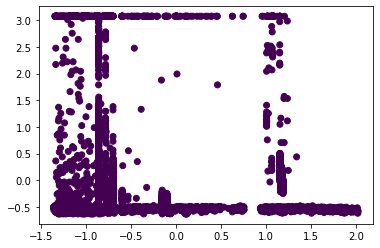

In [98]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[3], linkage=linkage[2])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [99]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.8719197952536678


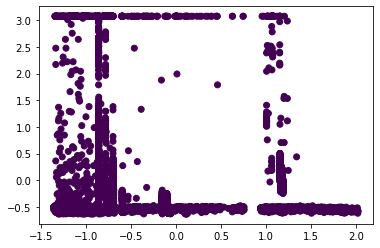

In [100]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[3], linkage=linkage[3])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [101]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.8834105859816775


##### AgglomerativeClustering with cosine affinity

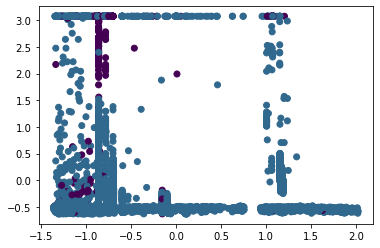

In [102]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[3], linkage=linkage[1])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [103]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.4869780510481968


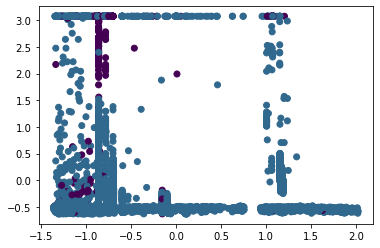

In [104]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[3], linkage=linkage[1])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [105]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.4869780510481968


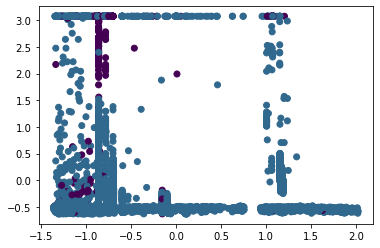

In [106]:
cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[3], linkage=linkage[1])
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [107]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))

Silhouette 0.4869780510481968


### Plot Cluster Results

[[-0.35500288 -0.48994814  0.03601844 -0.01853283  0.20256479  1.11472762
   0.46021178 -0.07601802 -0.09299149 -0.20536075  0.09748318  0.26745993
   0.97852193  0.69836089  1.22050258  1.05591524]
 [ 0.3626215  -0.23706327 -0.25323276 -0.13718374 -0.21804522 -0.40363881
  -0.16194226 -0.05712066 -0.07477898  0.02475377 -0.24928215 -0.35475803
  -0.71964216 -0.31687486 -0.57360865 -0.69418719]
 [-0.94980701  0.61833102  1.14623464  1.61945404  0.81528543  0.68796022
   0.44738173  3.78118413  4.75015656  4.43613823  2.65400922  3.20077492
  -0.43148155  0.34425129  0.37309163 -0.18671105]
 [-0.68591546  2.05674132  0.88726353  0.43382486  0.40454555 -0.79034294
  -0.36856819 -0.07660659 -0.08847999 -0.23648196  0.53427101  0.54956364
   1.05623745 -0.201024   -0.23368217  0.73919846]]


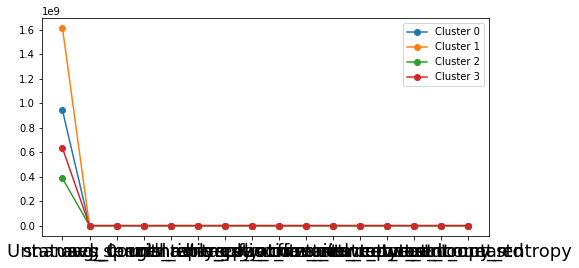

In [24]:
y_predict = res_cluster.fit_predict(X)
clf = NearestCentroid()
clf.fit(X, y_predict)
print(clf.centroids_)

centers = scaler.inverse_transform(clf.centroids_)
plot_parallel_coordinates_clusters(df, centers)

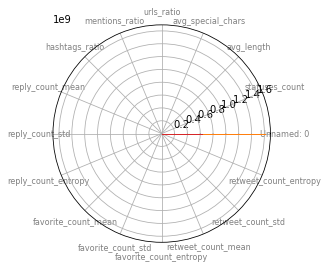

In [25]:
plot_radar_clusters(df, centers)

#### Distribution of CategoricalFeatures per Cluster

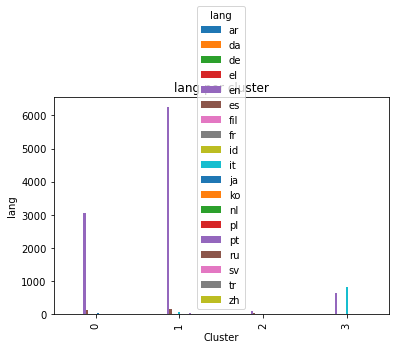

In [26]:
categorical_hist_clusters(df_cat, res_cluster.labels_, "lang")

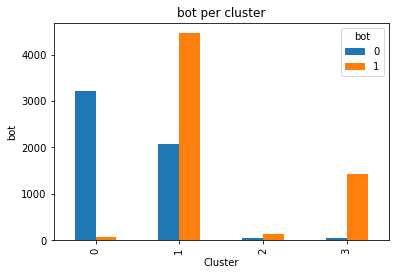

In [27]:
categorical_hist_clusters(df_cat, res_cluster.labels_, "bot")

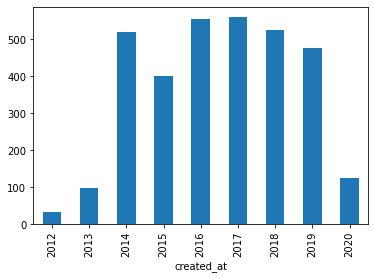

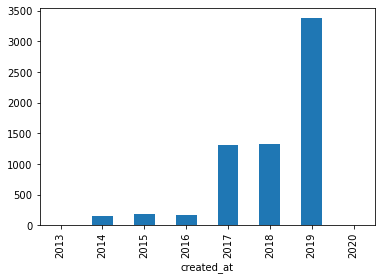

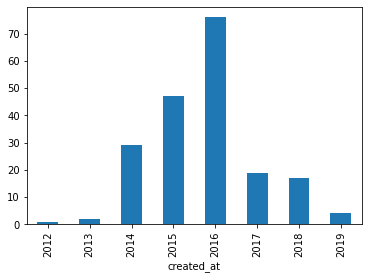

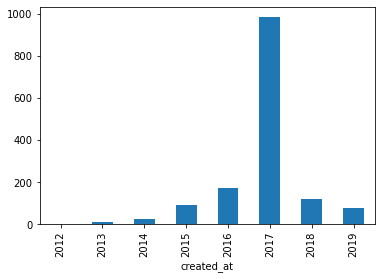

In [28]:
plot_date_feature_clusters(df, res_cluster.labels_, 4)

#### Distribution of Numerical Features per Cluster

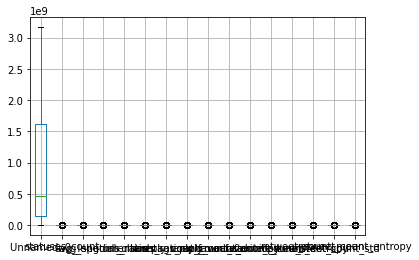

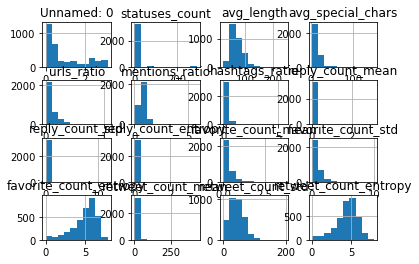

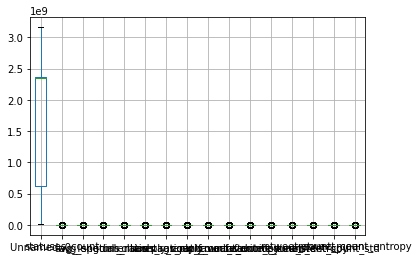

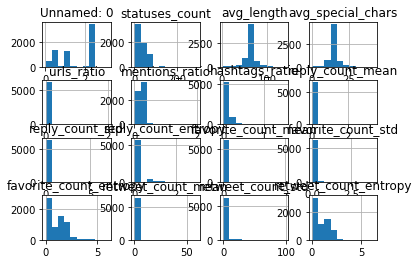

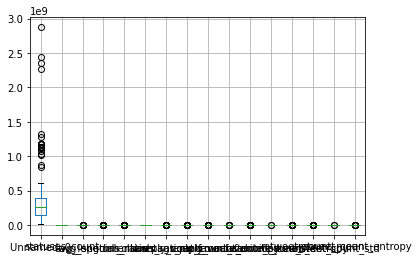

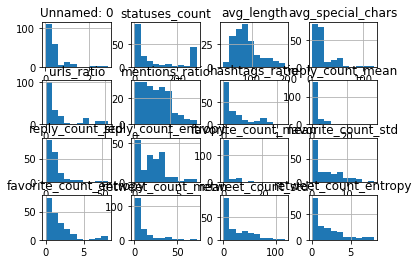

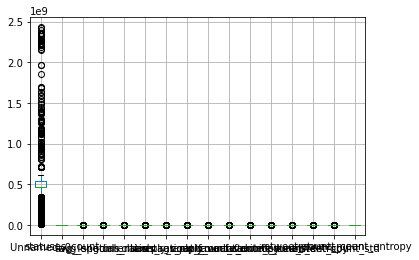

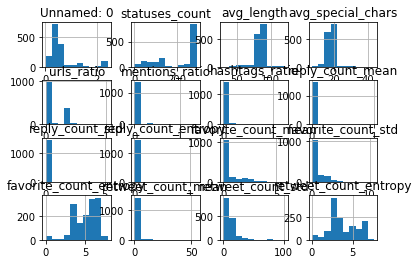

In [29]:
plot_numerical_features_clusters(df, res_cluster.labels_, 4)

Unnamed: 0 - statuses_count


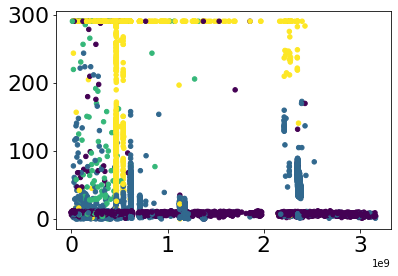

Unnamed: 0 - avg_length


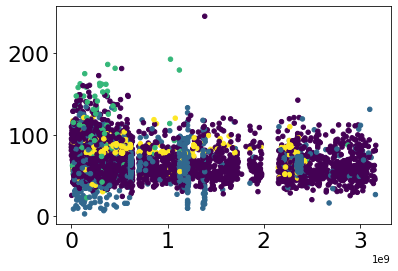

Unnamed: 0 - avg_special_chars


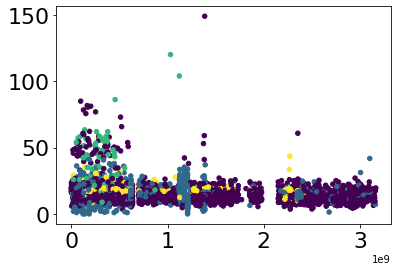

Unnamed: 0 - urls_ratio


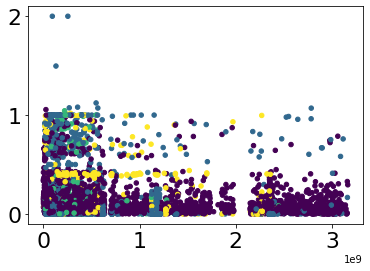

Unnamed: 0 - mentions_ratio


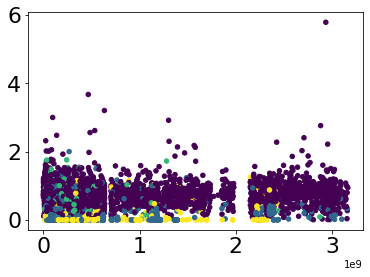

Unnamed: 0 - hashtags_ratio


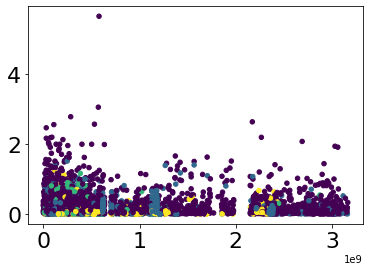

Unnamed: 0 - reply_count_mean


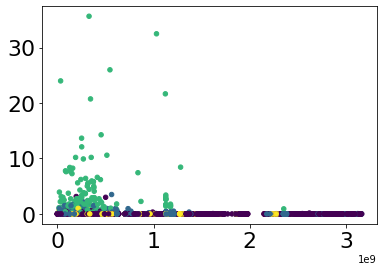

Unnamed: 0 - reply_count_std


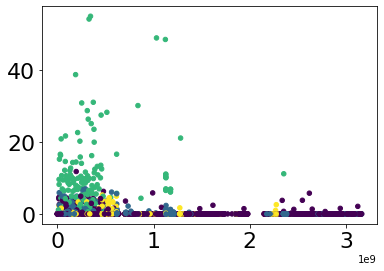

Unnamed: 0 - reply_count_entropy


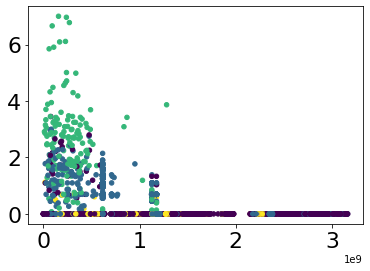

Unnamed: 0 - favorite_count_mean


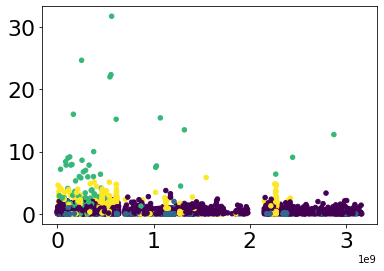

Unnamed: 0 - favorite_count_std


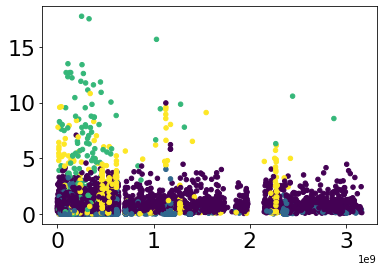

Unnamed: 0 - favorite_count_entropy


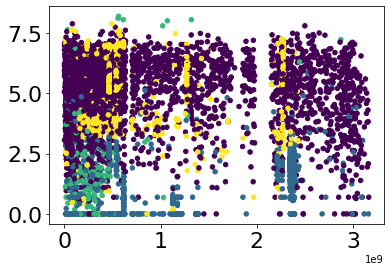

Unnamed: 0 - retweet_count_mean


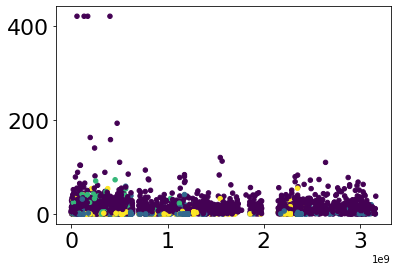

Unnamed: 0 - retweet_count_std


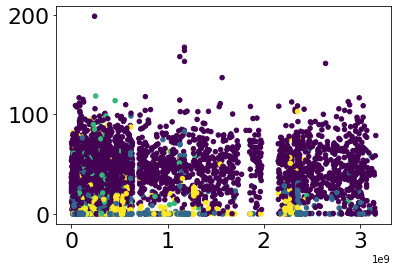

Unnamed: 0 - retweet_count_entropy


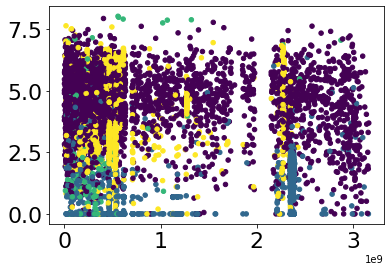

statuses_count - avg_length


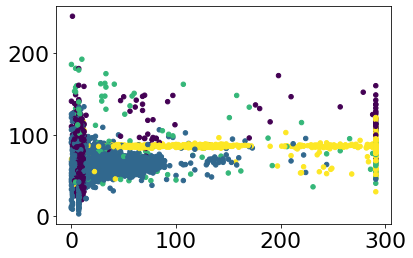

statuses_count - avg_special_chars


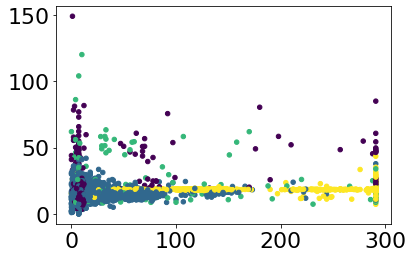

statuses_count - urls_ratio


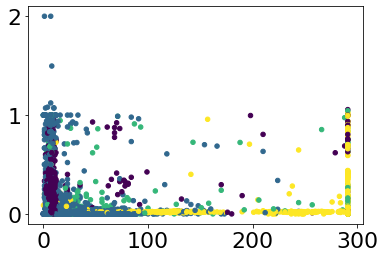

statuses_count - mentions_ratio


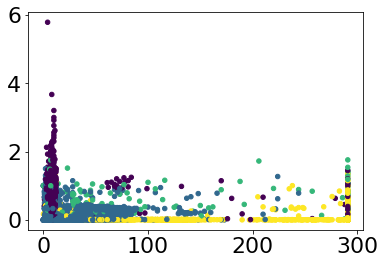

statuses_count - hashtags_ratio


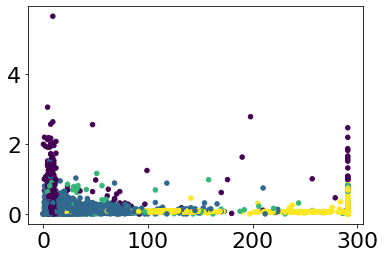

statuses_count - reply_count_mean


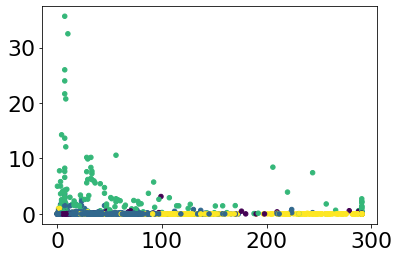

statuses_count - reply_count_std


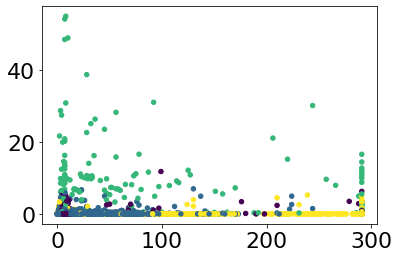

statuses_count - reply_count_entropy


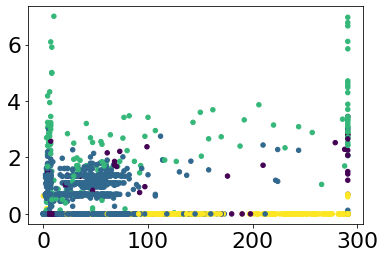

statuses_count - favorite_count_mean


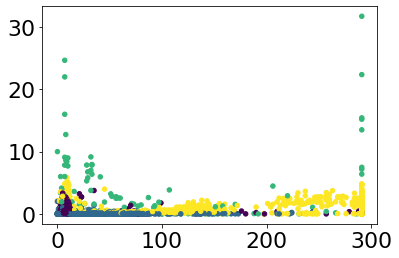

statuses_count - favorite_count_std


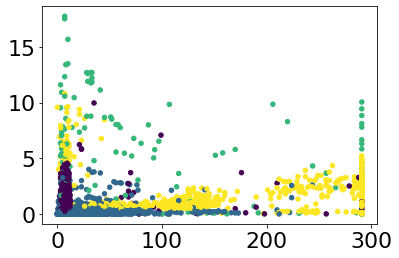

statuses_count - favorite_count_entropy


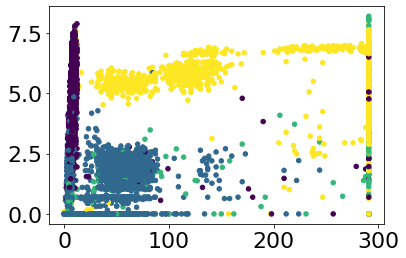

statuses_count - retweet_count_mean


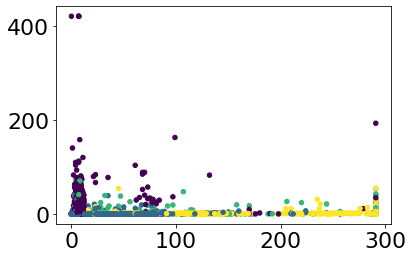

statuses_count - retweet_count_std


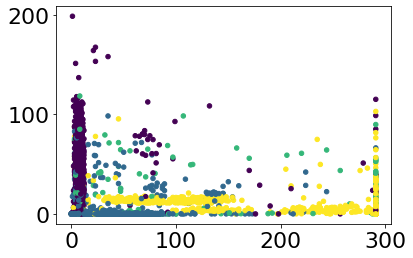

statuses_count - retweet_count_entropy


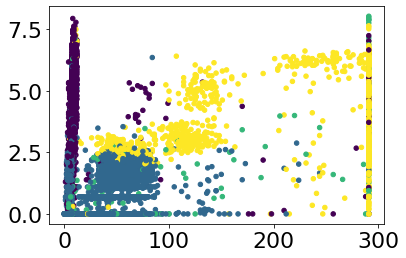

avg_length - avg_special_chars


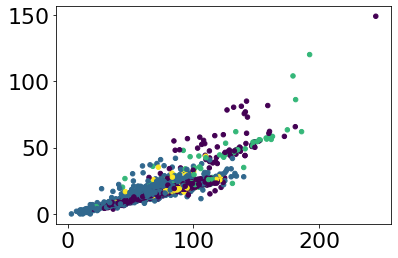

avg_length - urls_ratio


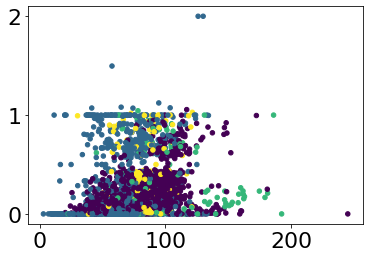

avg_length - mentions_ratio


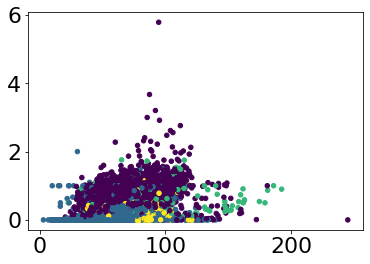

avg_length - hashtags_ratio


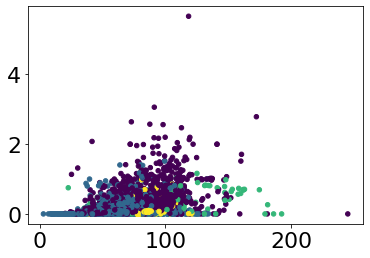

avg_length - reply_count_mean


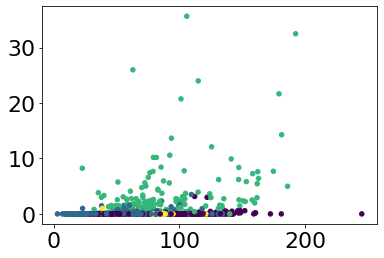

avg_length - reply_count_std


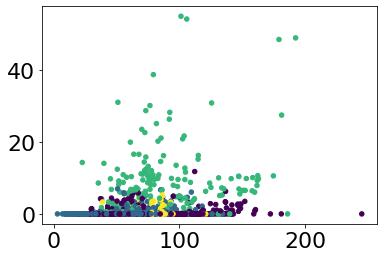

avg_length - reply_count_entropy


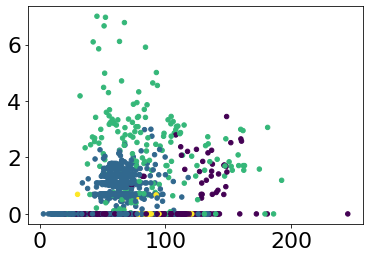

avg_length - favorite_count_mean


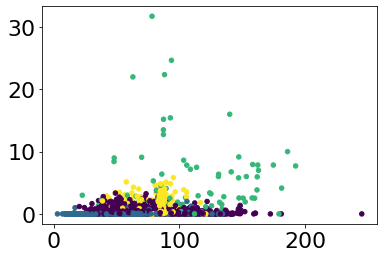

avg_length - favorite_count_std


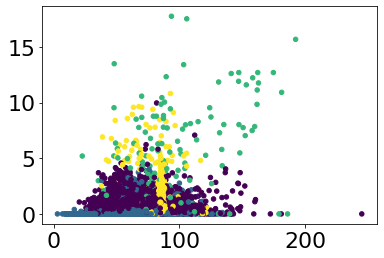

avg_length - favorite_count_entropy


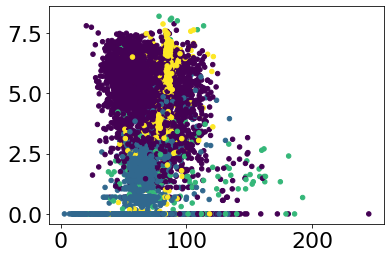

avg_length - retweet_count_mean


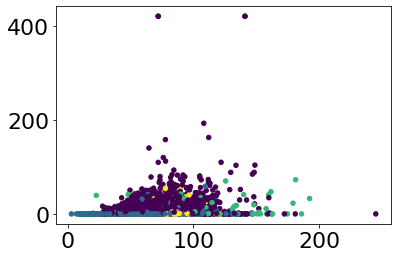

avg_length - retweet_count_std


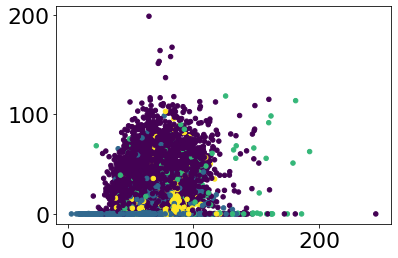

avg_length - retweet_count_entropy


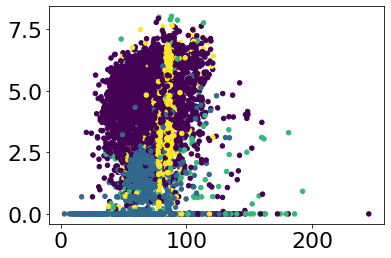

avg_special_chars - urls_ratio


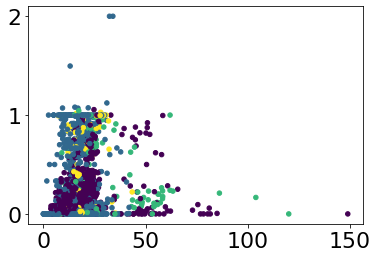

avg_special_chars - mentions_ratio


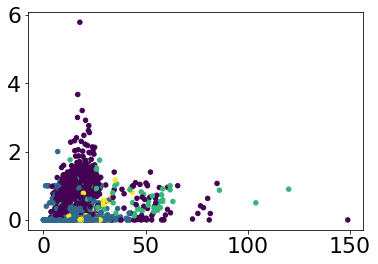

avg_special_chars - hashtags_ratio


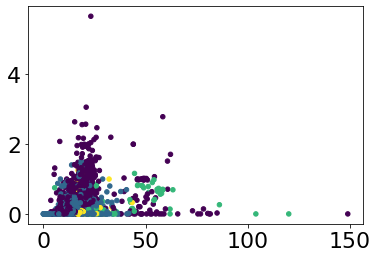

avg_special_chars - reply_count_mean


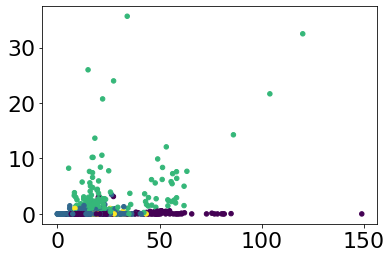

avg_special_chars - reply_count_std


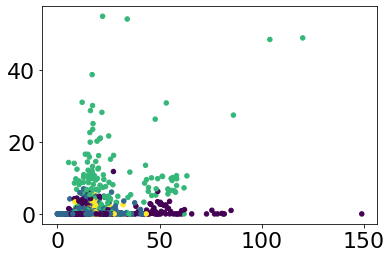

avg_special_chars - reply_count_entropy


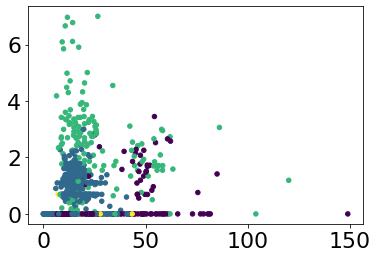

avg_special_chars - favorite_count_mean


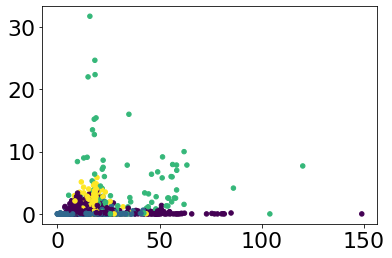

avg_special_chars - favorite_count_std


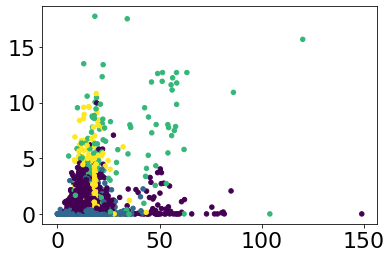

avg_special_chars - favorite_count_entropy


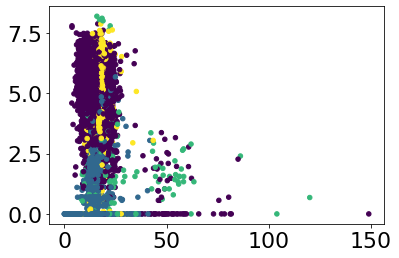

avg_special_chars - retweet_count_mean


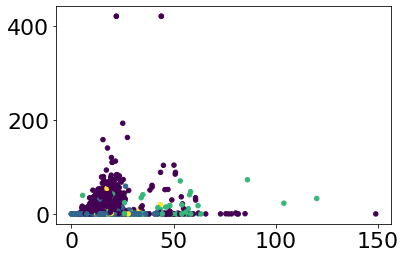

avg_special_chars - retweet_count_std


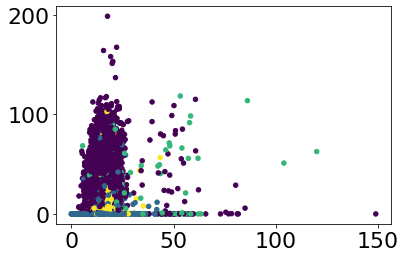

avg_special_chars - retweet_count_entropy


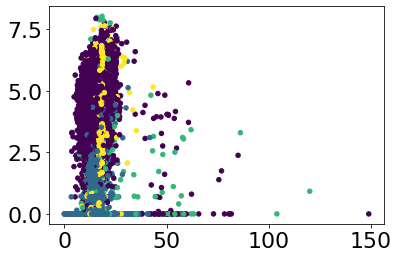

urls_ratio - mentions_ratio


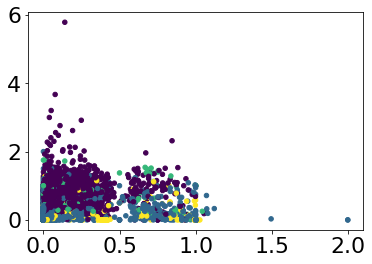

urls_ratio - hashtags_ratio


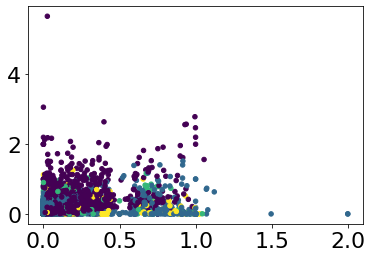

urls_ratio - reply_count_mean


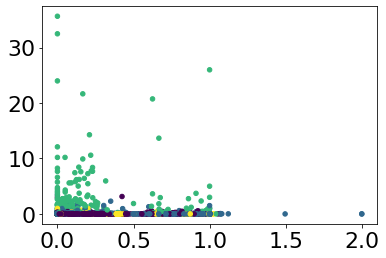

urls_ratio - reply_count_std


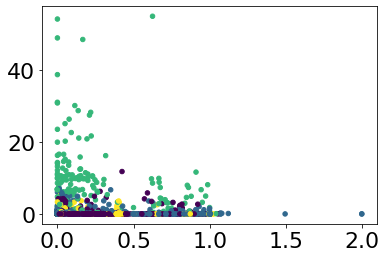

urls_ratio - reply_count_entropy


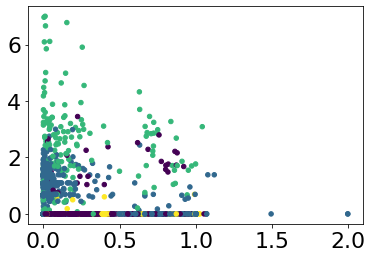

urls_ratio - favorite_count_mean


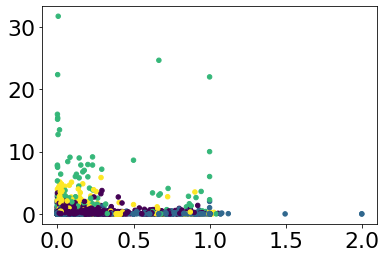

urls_ratio - favorite_count_std


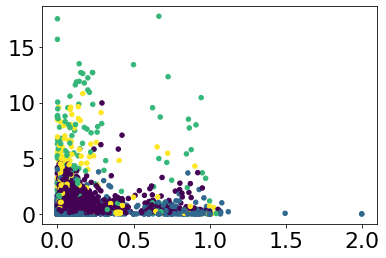

urls_ratio - favorite_count_entropy


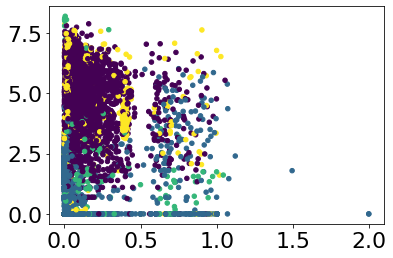

urls_ratio - retweet_count_mean


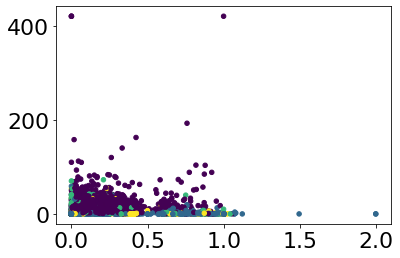

urls_ratio - retweet_count_std


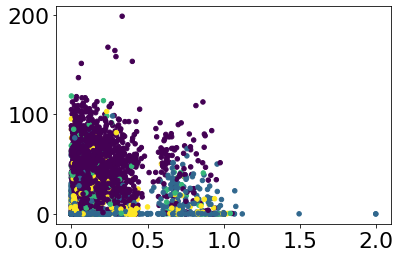

urls_ratio - retweet_count_entropy


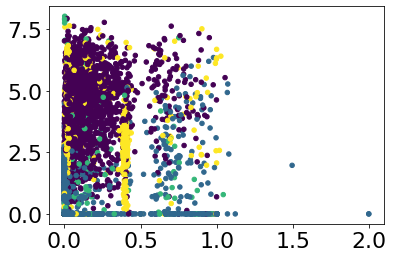

mentions_ratio - hashtags_ratio


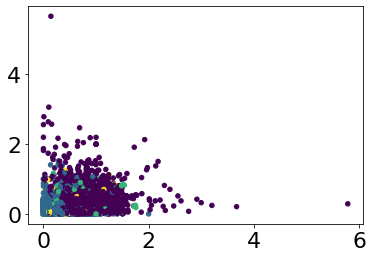

mentions_ratio - reply_count_mean


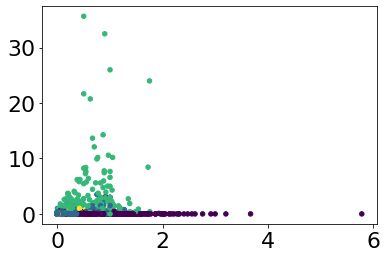

mentions_ratio - reply_count_std


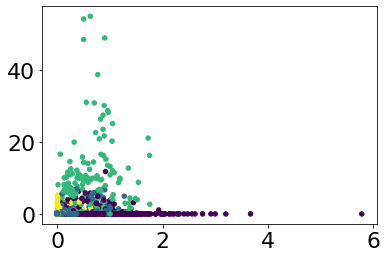

mentions_ratio - reply_count_entropy


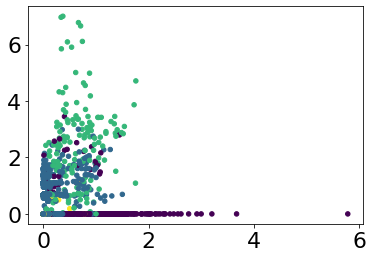

mentions_ratio - favorite_count_mean


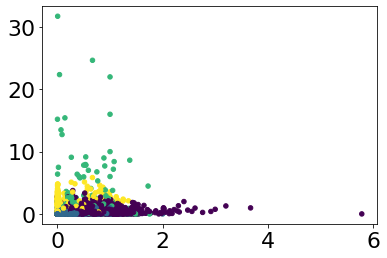

mentions_ratio - favorite_count_std


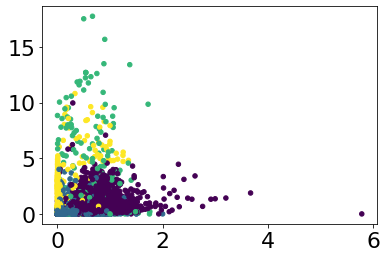

mentions_ratio - favorite_count_entropy


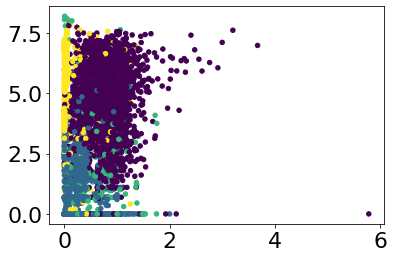

mentions_ratio - retweet_count_mean


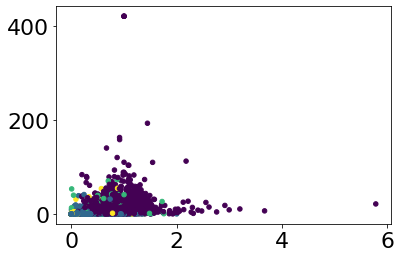

mentions_ratio - retweet_count_std


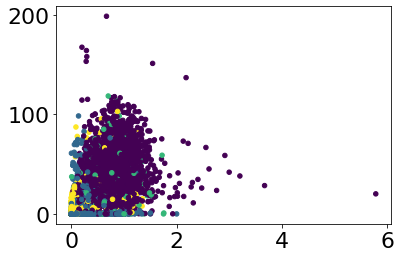

mentions_ratio - retweet_count_entropy


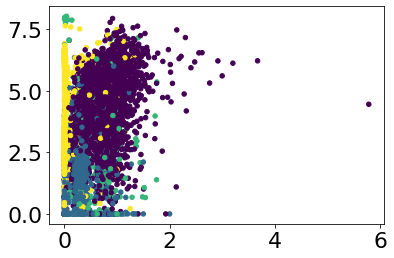

hashtags_ratio - reply_count_mean


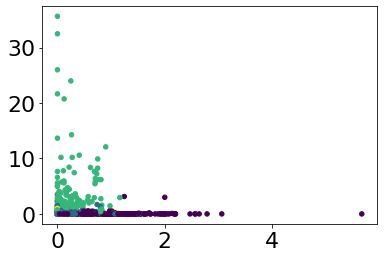

hashtags_ratio - reply_count_std


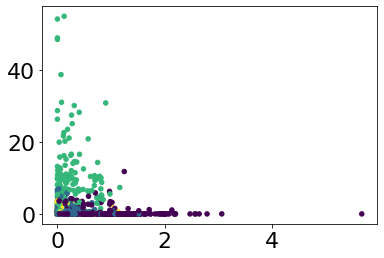

hashtags_ratio - reply_count_entropy


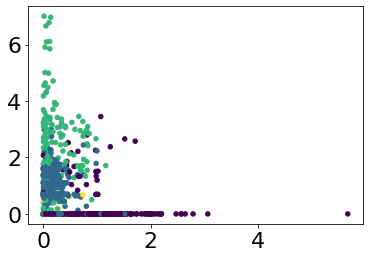

hashtags_ratio - favorite_count_mean


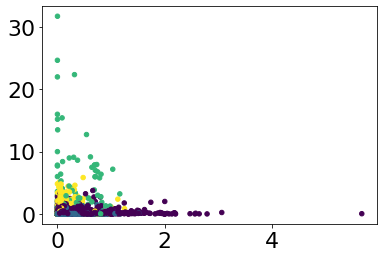

hashtags_ratio - favorite_count_std


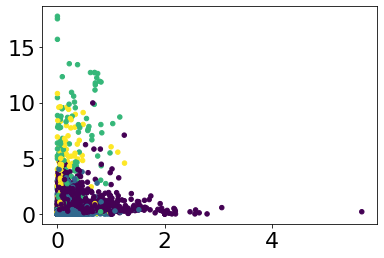

hashtags_ratio - favorite_count_entropy


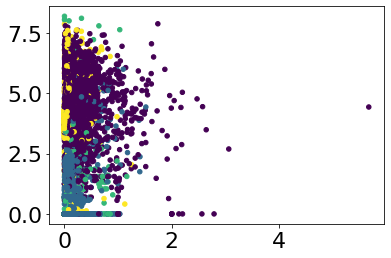

hashtags_ratio - retweet_count_mean


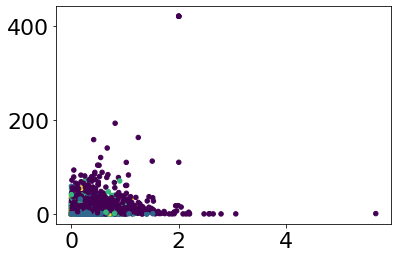

hashtags_ratio - retweet_count_std


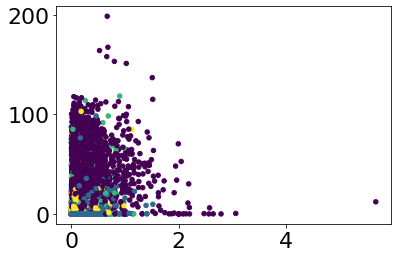

hashtags_ratio - retweet_count_entropy


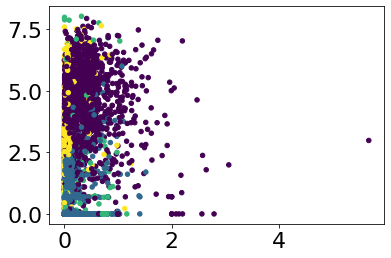

reply_count_mean - reply_count_std


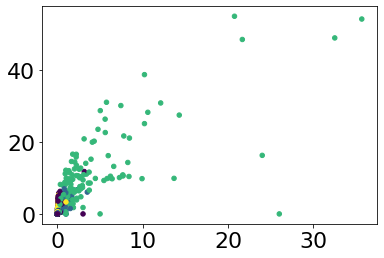

reply_count_mean - reply_count_entropy


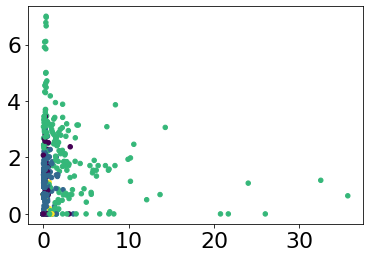

reply_count_mean - favorite_count_mean


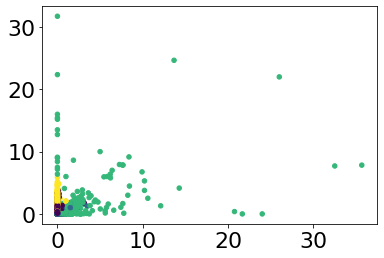

reply_count_mean - favorite_count_std


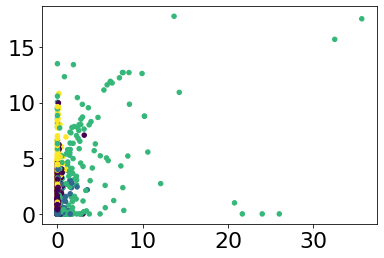

reply_count_mean - favorite_count_entropy


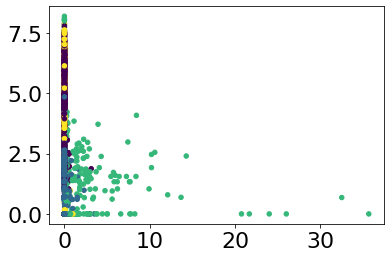

reply_count_mean - retweet_count_mean


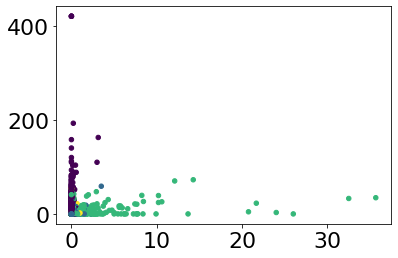

reply_count_mean - retweet_count_std


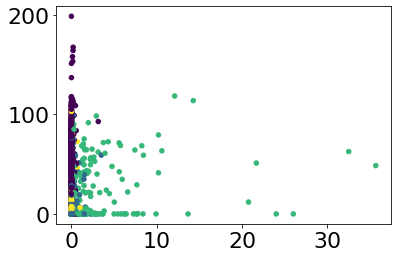

reply_count_mean - retweet_count_entropy


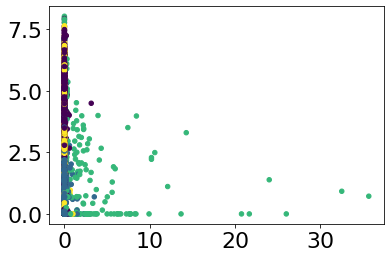

reply_count_std - reply_count_entropy


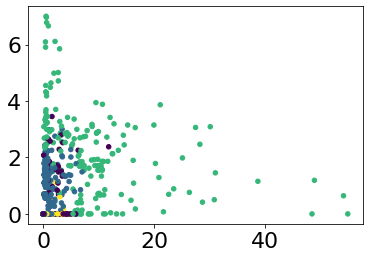

reply_count_std - favorite_count_mean


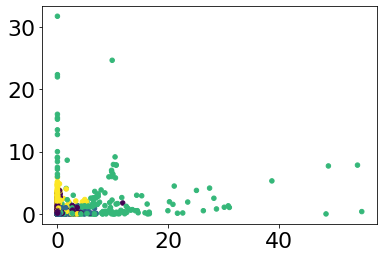

reply_count_std - favorite_count_std


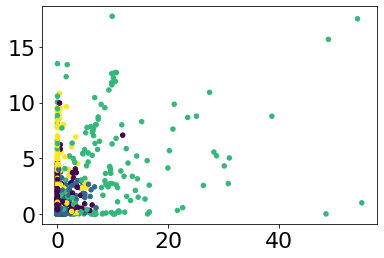

reply_count_std - favorite_count_entropy


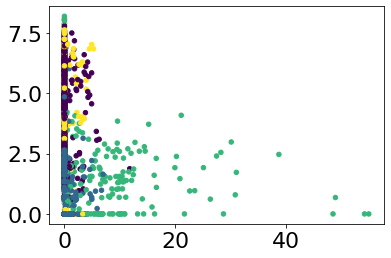

reply_count_std - retweet_count_mean


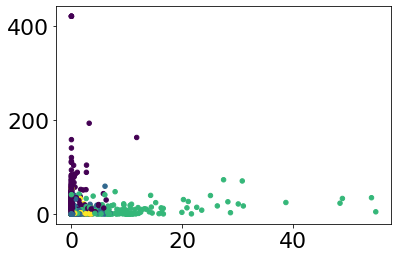

reply_count_std - retweet_count_std


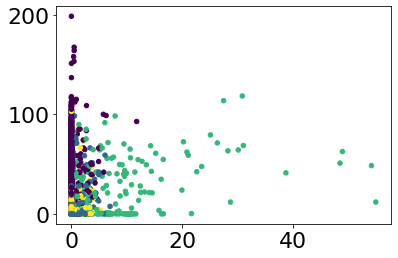

reply_count_std - retweet_count_entropy


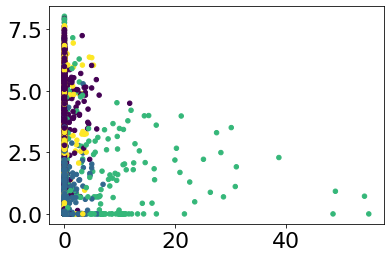

reply_count_entropy - favorite_count_mean


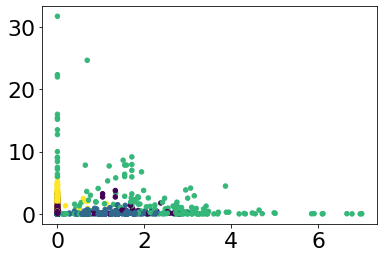

reply_count_entropy - favorite_count_std


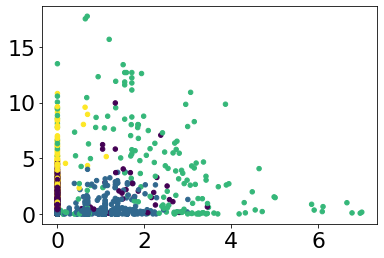

reply_count_entropy - favorite_count_entropy


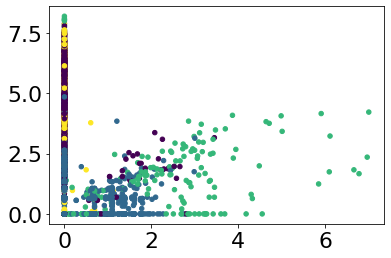

reply_count_entropy - retweet_count_mean


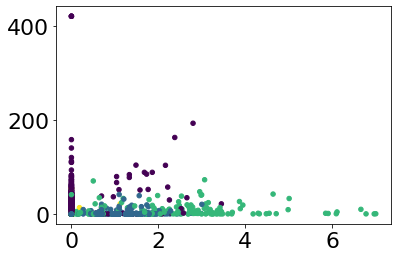

reply_count_entropy - retweet_count_std


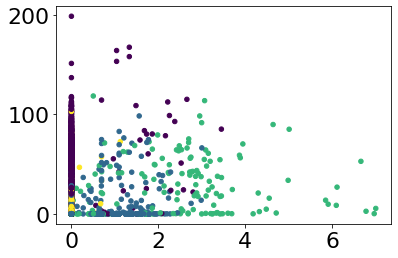

reply_count_entropy - retweet_count_entropy


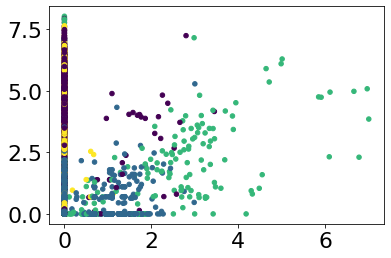

favorite_count_mean - favorite_count_std


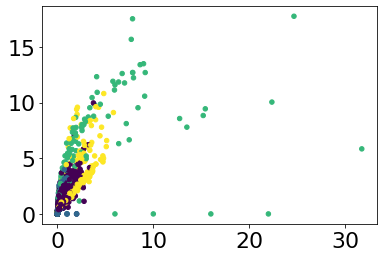

favorite_count_mean - favorite_count_entropy


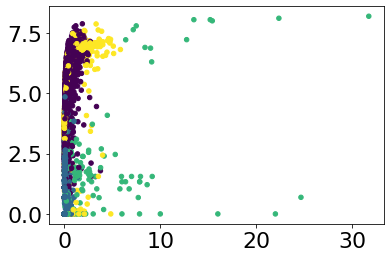

favorite_count_mean - retweet_count_mean


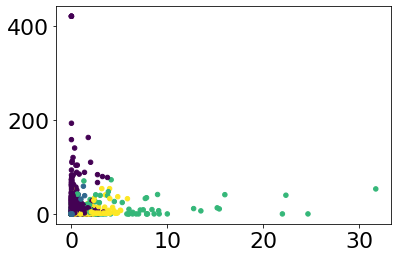

favorite_count_mean - retweet_count_std


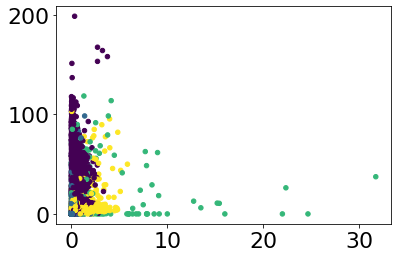

favorite_count_mean - retweet_count_entropy


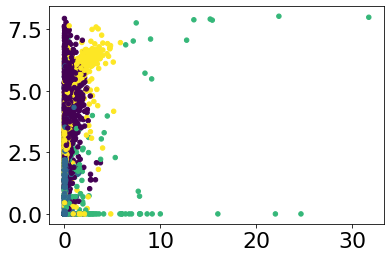

favorite_count_std - favorite_count_entropy


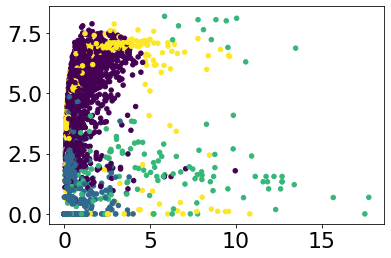

favorite_count_std - retweet_count_mean


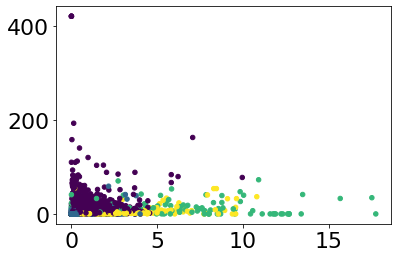

favorite_count_std - retweet_count_std


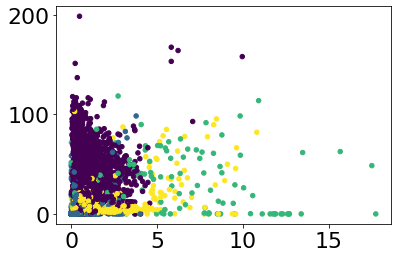

favorite_count_std - retweet_count_entropy


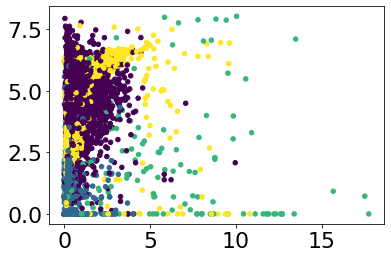

favorite_count_entropy - retweet_count_mean


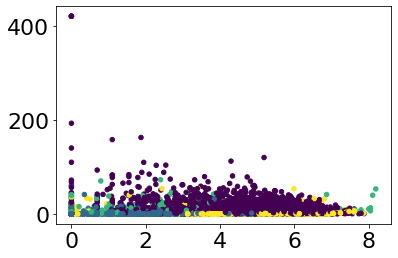

favorite_count_entropy - retweet_count_std


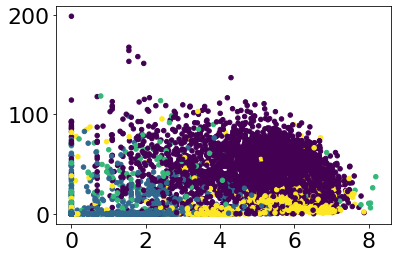

favorite_count_entropy - retweet_count_entropy


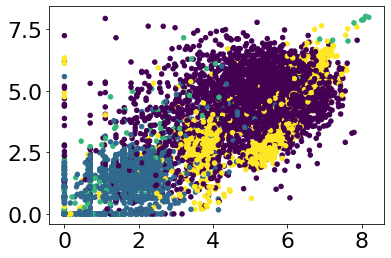

retweet_count_mean - retweet_count_std


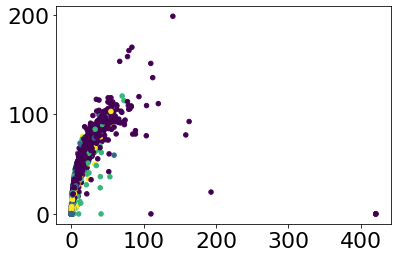

retweet_count_mean - retweet_count_entropy


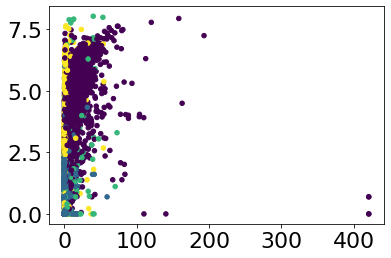

retweet_count_std - retweet_count_entropy


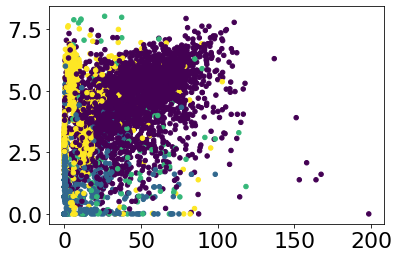

In [30]:
scatter_features_clusters(df, res_cluster.labels_)

# dbscan

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [24]:
dbscan = DBSCAN(eps=0.12, min_samples=7)
dbscan.fit(X)

DBSCAN(eps=0.12, min_samples=7)

In [25]:
dbscan.labels_[:5]

array([ 0,  0,  1,  2, -1], dtype=int64)

In [26]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64),
 array([1886, 3381, 2796, 2914,   43,  390,   55,   11,    8,   17,    7],
       dtype=int64))

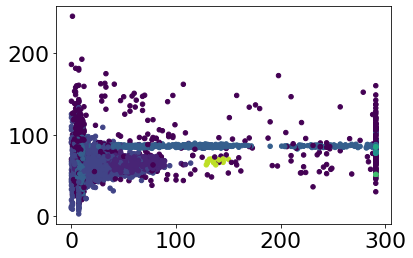

In [27]:
plt.scatter(df['statuses_count'], df['avg_length'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [28]:
print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.21276067691804373


In [29]:
dist = pdist(X, 'euclidean') #pair wise distance
print (dist)
dist = squareform(dist) #distance matrix given the vector dist
print()
print(dist)

[0.25863302 0.81433974 0.75439032 ... 0.86902664 1.15701941 0.89786183]

[[0.         0.25863302 0.81433974 ... 0.86838974 0.13366844 0.95711405]
 [0.25863302 0.         0.780808   ... 0.82371521 0.15984343 0.95686777]
 [0.81433974 0.780808   0.         ... 0.40422404 0.8188535  1.11974589]
 ...
 [0.86838974 0.82371521 0.40422404 ... 0.         0.86902664 1.15701941]
 [0.13366844 0.15984343 0.8188535  ... 0.86902664 0.         0.89786183]
 [0.95711405 0.95686777 1.11974589 ... 1.15701941 0.89786183 0.        ]]


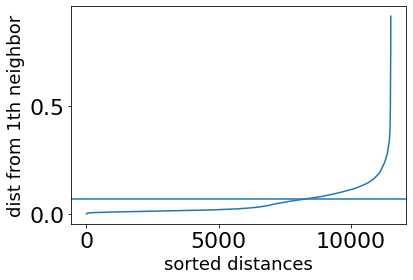

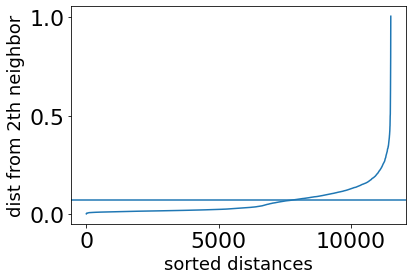

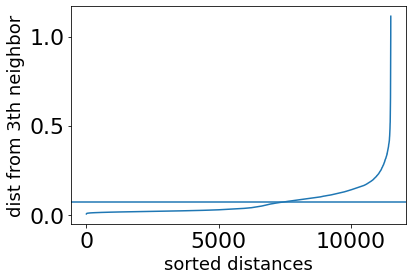

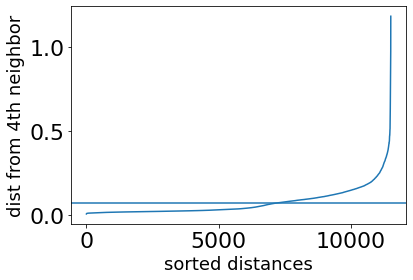

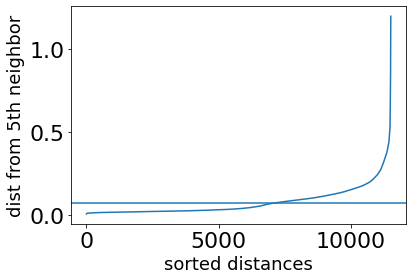

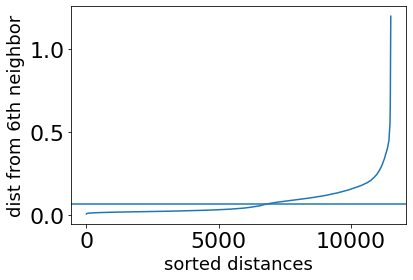

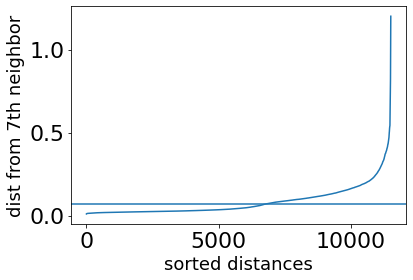

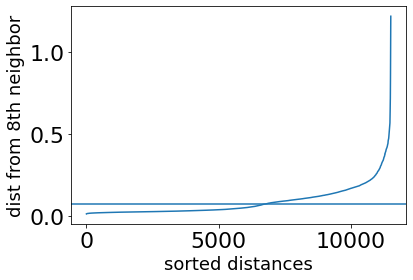

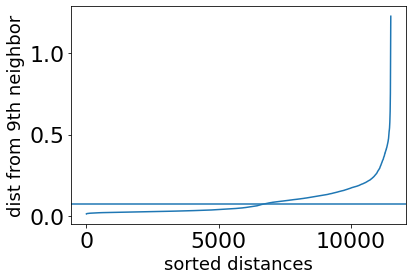

In [30]:
for k in range (1, 10):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.axhline(y=0.07)
    plt.show()

### Plot Cluster Results